In [1]:
import aesara.tensor as at
import numpy as np
import pandas as pd

from aesara.tensor import TensorVariable
from aesara.tensor.random.op import RandomVariable

import pymc as pm
from pymc.distributions.continuous import PositiveContinuous
from pymc.distributions.dist_math import check_parameters

import matplotlib.pyplot as plt
import arviz as az

In [2]:
rng = np.random.RandomState(seed=34)
T = 10
T0 = 0
p = 0.2
lam = 0.5

size = (5, 3)

In [3]:
class CustomerLifetimeValueRV(RandomVariable):
    name = "customer_lifetime_value"
    ndim_supp = 1
    ndims_params = [0, 0, 0, 0]
    dtype = "floatX"
    _print_name = ("CustomerLifetimeValue", "\\operatorname{CustomerLifetimeValue}")

    def make_node(self, rng, size, dtype, lam, p, T, T0):

        T = at.as_tensor_variable(T)
        T0 = at.as_tensor_variable(T0)

        # T0 and T cannot be random variables
        if T.owner is not None:
            raise ValueError("T must be a scalar, i.e. observed, and not random quantities.")

        if T0.owner is not None:
            raise ValueError("T0 must be a scalar, i.e. observed, and not random quantities.")

        return super().make_node(rng, size, dtype, lam, p, T, T0)

    def __call__(self, lam, p, T, T0=0, size=None, **kwargs):
        return super().__call__(lam, p, T, T0, size=size, **kwargs)
    
    def _infer_shape(self, size, dist_params, param_shapes=None):
        size = tuple(size)
        
        return size + (2,)

    @classmethod
    def rng_fn(cls, rng, lam, p, T, T0, size) -> np.array:

        if size is None:
            size = ()
        elif isinstance(size, int):
            size = (size,)
        else:
            size = tuple(size)
        
        # to do
        lam = np.array(lam)
        p = np.array(p)
        T = np.array(T)
        T0 = np.array(T0)
        
        output = np.empty(shape=size + (2,))
        
        def sim_data():
            t = 0
            n = 0
            
            while True:
                wait = rng.exponential(scale=1/lam)
                dropout = rng.binomial(n=1, p=p)
                
                if t + wait > T:
                    break
                else:
                    t += wait
                    n += 1
                    
                    if dropout == 1:
                        break
            
            return np.array(
                [
                    t,
                    n,
                ],
            )
        
        for index in np.ndindex(*size):
            output[index] = sim_data()
        
        return output


customer_lifetime_value = CustomerLifetimeValueRV()
            
            
class CustomerLifetimeValue(PositiveContinuous):
    rv_op = customer_lifetime_value
    
    @classmethod
    def dist(cls, lam, p, T, T0, **kwargs):
        return super().dist([lam, p, T, T0], **kwargs)
    
    def get_moment(rv, size, lam, p, T, T0):
        if size is None:
            size = (2,)
        elif isinstance(size, int):
            size = (size,) + (2,)
        else:
            size = tuple(size) + (2,)
        
        return at.full(size, at.as_tensor_variable([lam, p]))
    
    def logp(value, lam, p, T, T0):
        t_x = value[..., 0]
        x = value[..., 1]
        
        zero_observations = at.eq(x, 0)
        
        A = x*at.log(1 - p) + x*at.log(lam) - lam*T
        B = at.log(p) + (x - 1)*at.log(1 - p) + x*at.log(lam) - lam*t_x
        
        logp = at.switch(
            zero_observations,
            A,
            at.logaddexp(A, B),
        )
        
        return check_parameters(
            logp,
            lam > 0,
            0 <= p,
            p <= 1,
            at.all(T0 < T),
            msg="lam > 0, 0 <= p <= 1, T0 < T",
        )

In [4]:
simulated_data = customer_lifetime_value.rng_fn(rng, lam, p, T, T0, size=[1000,])

In [5]:
with pm.Model() as model:

    λ = pm.Gamma(name="λ", alpha=0.1, beta=0.1)
    π = pm.Beta(name="π", alpha=1, beta=1)
    
    clv = CustomerLifetimeValue(
        name="clv",
        lam=λ,
        p=π,
        T=10,
        T0=0,
        observed=simulated_data,
    )
    
    trace = pm.sample(draws=10000, chains=1, tune=5000)

Sequential sampling (1 chains in 1 job)
NUTS: [λ, π]


Sampling 1 chain for 5_000 tune and 10_000 draw iterations (5_000 + 10_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


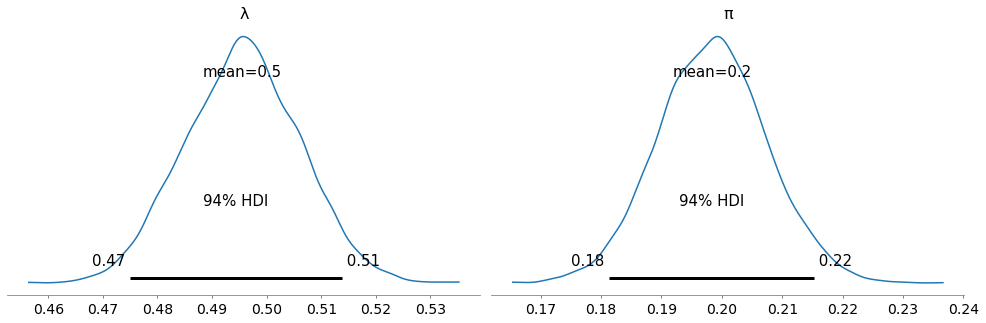

In [6]:
_ = az.plot_posterior(trace)
plt.tight_layout()

In [7]:
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.datasets import load_dataset

cdnow_transactions = load_dataset(
    'CDNOW_sample.txt', 
    header=None, 
    delim_whitespace=True, 
    names=['customer_id', 'customer_index', 'date', 'quantity', 'amount'],
    converters={'date': lambda x: pd.to_datetime(x, format="%Y%m%d")}
)


rfm = summary_data_from_transaction_data(
    cdnow_transactions,
    "customer_id",
    "date",
    observation_period_end=pd.to_datetime("1997-09-30"),
    freq='W'
)

frequency = rfm["frequency"].to_numpy()
tx = rfm["recency"].to_numpy()
T = rfm["T"].to_numpy()